# Recommendation System Project

<b>Project Goal </b>: Build your own recommendation system for products on an e-commerce website like Amazon.com.

<br>Dataset columns - first three columns are userId, productId, and ratings and the fourth column is
timestamp. You can discard the timestamp column as in this case you may not need to use it.
<br><br>Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has
several datasets. For this case study, we are using the Electronics dataset.
<br><br>Please do the analysis based on steps( 1 to 8) as given below -
<br><br>Steps -
1. Read and explore the given dataset. ( Rename column/add headers, plot histograms,
find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the
users only who has given 50 or more number of ratings )
3. Build Popularity Recommender model.
4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
5. Build Collaborative Filtering model.
6. Evaluate the above model. ( Once the model is trained on the training data, it can be
used to compute the error (like RMSE) on predictions made on the test data.) You can
also use a different method to evaluate the models.
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to
each user based on his/her habits, we will recommend 5 new products.
8. Summarise your insights.

In [2]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

### 1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics)

In [8]:
colnames = ["UserID", "ProductID", "Rating", "Timestamp"]
df_data = pd.read_csv("ratings_Electronics.csv")
df_data.columns = colnames
print("Shape: ",df_data.shape)
df_data.head()

Shape:  (7824481, 4)


,UserID,ProductID,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [9]:
#Drop Timestamp column as it's not significant
df_data.drop(['Timestamp'],axis=1,inplace=True)

In [10]:
print(df_data.describe(),"\n\nInfo command output \n")
print(df_data.info())

             Rating
count  7.824481e+06
mean   4.012337e+00
std    1.380910e+00
min    1.000000e+00
25%    3.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00 

Info command output 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
UserID       object
ProductID    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB
None


In [11]:
df_data.isnull().sum().sort_values(ascending=False)

Rating       0
ProductID    0
UserID       0
dtype: int64

In [12]:
new_col = ["UserID", "ProductID", "Rating"]
print(df_data.ix[df_data['Rating'] < 0])


Empty DataFrame
Columns: [UserID, ProductID, Rating]
Index: []


In [13]:
df_data[pd.to_numeric(df_data['ProductID'], errors='coerce').isnull()]['ProductID'].head(10)

38      059400232X
39      059400232X
40      059400232X
162     089933623X
163     089933623X
174     094339676X
1280    134048160X
2490    140053271X
2491    140053271X
2492    140053271X
Name: ProductID, dtype: object

In [14]:
df_data[pd.to_numeric(df_data['UserID'], errors='coerce').isnull()]['UserID'].head(10)

0    A2CX7LUOHB2NDG
1    A2NWSAGRHCP8N5
2    A2WNBOD3WNDNKT
3    A1GI0U4ZRJA8WN
4    A1QGNMC6O1VW39
5    A3J3BRHTDRFJ2G
6    A2TY0BTJOTENPG
7    A34ATBPOK6HCHY
8     A89DO69P0XZ27
9     AZYNQZ94U6VDB
Name: UserID, dtype: object

In [15]:
df_data.groupby(['Rating']) ['Rating'].count()

Rating
1.0     901765
2.0     456322
3.0     633073
4.0    1485781
5.0    4347540
Name: Rating, dtype: int64

#### Points to be noted <br>
1. It looks like userID and ProductID have alphanumeric values and not just numeric
2. There are no null values in Rating column
3. Most of the ratings are 5

Lets analyze things visually

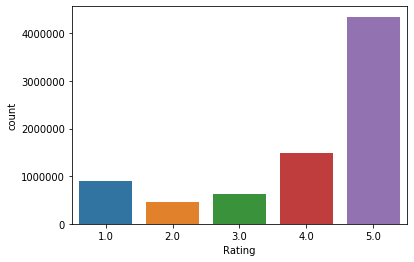

In [16]:
sns.countplot(data=df_data , x='Rating')
plt.show()

In [17]:
df_data.groupby(['UserID']) ['UserID'].count().sort_values(ascending=False).head(20)

UserID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
Name: UserID, dtype: int64

In [87]:
# numbers of unique users
print("Unique users: ", len(df_data.UserID.unique()))

# numbers of unique products
print("Unique Products ", len(df_data.ProductID.unique()))

Unique users:  4201696
Unique Products  476001


In [18]:
#Analysis of count of reviews for product and respective mean of ratings

mr = df_data.groupby('ProductID').mean()['Rating']
print(mr.head())
cnt = df_data.groupby('ProductID').count()['Rating']
cnt.head()


ProductID
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
Name: Rating, dtype: float64


ProductID
0321732944     1
0439886341     3
0511189877     6
0528881469    27
0558835155     1
Name: Rating, dtype: int64

In [19]:
# Create a dataframe to combine mean rating and count against a product and perform analysis
pr_df = pd.DataFrame(data={'Mean Rating':mr,'count':cnt})
pr_df.sort_values(by='count',ascending=False).head()

,Mean Rating,count
ProductID,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226


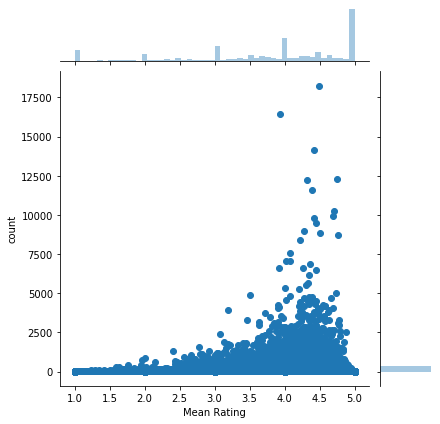

In [20]:
sns.jointplot(pr_df['Mean Rating'],pr_df['count'])

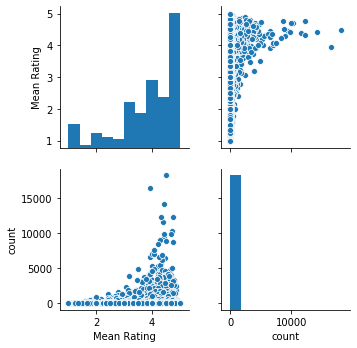

In [21]:
sns.pairplot(pr_df)

#### EDA conclusions

1. It looks like userID and ProductID have alphanumeric values and not just numeric
2. There are no null values in Rating column
3. Most of the ratings are 5 ( More than 50% it seems )
4. Most of the products with high mean rating got more number of reviews
5. The products with low ratings got very less number of reviews

Looks like a trend where more people tend to give review if they really like the product

### 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [22]:
counts = df_data['UserID'].value_counts()
df_data50 = df_data[df_data['UserID'].isin(counts[counts >= 50].index)]
df_data50.head(10)

,UserID,ProductID,Rating
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0
1002,A2Y4H3PXB07WQI,0972683275,4.0
1137,A25RTRAPQAJBDJ,0972683275,5.0
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0


In [23]:
df_data50.shape

(125871, 3)

In [38]:

df_data50.UserID = df_data50.UserID.astype(str)
df_data50.ProductID = df_data50.ProductID.astype(str)

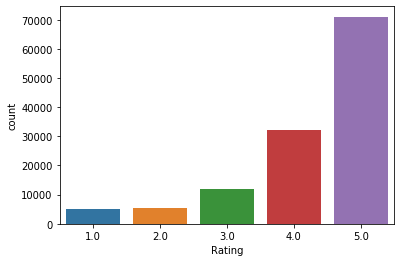

In [39]:
sns.countplot(data=df_data50 , x='Rating')
plt.show()

In [40]:
# numbers of unique users
print("Unique users: ", len(df_data50.UserID.unique()))

# numbers of unique products
print("Unique Products ", len(df_data50.ProductID.unique()))

Unique users:  1540
Unique Products  48190


### 3. Build Popularity Recommender model

In [41]:
# Count of useid for each unique productid as recommendation score 

df_data_agg = df_data50.groupby('ProductID').agg({'UserID': 'count'}).reset_index()
df_data_agg.rename(columns = {'UserID': 'score'},inplace=True)
df_data_agg.head()

,ProductID,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [42]:
# Sorting productid on recommendation score 
df_data_agg1 = df_data_agg.sort_values(['score', 'ProductID'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score 
df_data_agg1['Rank'] = df_data_agg1['score'].rank(ascending=0, method='first') 

#Get the top 5 recommendations 
data_recom = df_data_agg1.head(5) 
data_recom

,ProductID,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


In [43]:
# Use popularity based recommender model to make predictions
def recommend(useid):     
    useid_recom = data_recom 
          
    #Add user_id column for which the recommendations are being generated 
    useid_recom['UserID'] = useid 
      
    #Bring user_id column to the front 
    cols = useid_recom.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    useid_recom = useid_recom[cols] 
          
    return useid_recom

In [44]:
find_recom = [10,125,200]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the useid: %d\n" %(i))
    print(recommend(i))    
    print("\n")

Here is the recommendation for the useid: 10

       UserID   ProductID  score  Rank
39003      10  B0088CJT4U    206   1.0
24827      10  B003ES5ZUU    184   2.0
11078      10  B000N99BBC    167   3.0
38250      10  B007WTAJTO    164   4.0
38615      10  B00829TIEK    149   5.0


Here is the recommendation for the useid: 125

       UserID   ProductID  score  Rank
39003     125  B0088CJT4U    206   1.0
24827     125  B003ES5ZUU    184   2.0
11078     125  B000N99BBC    167   3.0
38250     125  B007WTAJTO    164   4.0
38615     125  B00829TIEK    149   5.0


Here is the recommendation for the useid: 200

       UserID   ProductID  score  Rank
39003     200  B0088CJT4U    206   1.0
24827     200  B003ES5ZUU    184   2.0
11078     200  B000N99BBC    167   3.0
38250     200  B007WTAJTO    164   4.0
38615     200  B00829TIEK    149   5.0




#### Finding: Its a popularity-based recommender model, therefore recommendations remain the same for all users


### 4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [45]:
from sklearn.model_selection import train_test_split

trainDF, testDF = train_test_split(df_data50, test_size=0.3, random_state=100)
print(trainDF.head(10))
print(testDF.head(10))

                 UserID   ProductID  Rating
5993537   ANW6EGY12V5XS  B007ZW43IQ     4.0
4459174  A1QVFHPY8418HC  B004T9Y0MW     5.0
2177399   ALDAF4VVLFRHP  B001NOG2T0     4.0
232286   A11YIHB6IW352W  B00007KDVI     5.0
7811982  A3PD8JD9L4WEII  B00JGSWU7S     5.0
428041   A3H4S6YO9VNGDZ  B000234TYI     4.0
6249103   A28P7V9KI7MXP  B008I6SHMQ     5.0
3708841  A27TN8D0CZ8LUY  B003ZS0UXG     4.0
5853099  A35HOUWHAYZZN6  B007PTCFFW     5.0
3363313   A3IK2VCQ007CJ  B003GZ828I     5.0
                 UserID   ProductID  Rating
3071496   AWH2AY17ZU7W2  B0035JCI6M     3.0
1270451  A2MSBIA18RXYQC  B000P1711K     1.0
1506248  A1H98YV5K5BUX0  B000WZ7Y5C     5.0
7709305  A2X8KN82L07RSK  B00GO4GMAI     5.0
2570182   AU627A4UGIW6V  B002EPF6YO     4.0
21786    A33152QEGO2MZN  B00001P4XH     5.0
4463751  A1CMD08Z49PGKQ  B004TIIBMS     5.0
3527512   ARW8VGT10JG60  B003S0YC5I     4.0
890593   A3KTWUXXB8KKC7  B000EWD6YG     5.0
313966    AC6Z7DP1Z5GHD  B0000AB4O9     5.0


### 5. Build Collaborative Filtering model.

In [49]:
# We need to ensure that user in test data shall be avaiable in training data set for recomendation.
# for this we will copy the test dataset and make that user rating as np.nan

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

Ratings = Reader(rating_scale=(1, 5))

SVDModel = SVD(n_factors = 50, reg_all = 0.01, lr_all = 0.001)

data = Dataset.load_from_df(df_data50[['UserID', 'ProductID', 'Rating']], Ratings)

trainDF, testDF = train_test_split(data, test_size=0.3, random_state=100)

In [50]:
SVDModel.fit(trainDF)

In [51]:
test_pred = SVDModel.test(testDF)

In [52]:
accuracy.rmse(test_pred)

RMSE: 0.9978


0.9978235428705134

#### Optimizing the model by finding the best hyper parameters using Grid Search CV

In [53]:
from surprise.model_selection import GridSearchCV
    
param_grid = {'n_factors' : [5,10,15],'lr_all': [0.001, 0.003, 0.005, 0.007,0.009],'reg_all': [0.01, 0.02,0.03]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

gs.fit(data)

In [54]:
# get best parameters
print("Optimal parameters: ", gs.best_params)

# get best score
print("Optimal score: ", gs.best_score['rmse'])

Optimal parameters:  {'rmse': {'n_factors': 5, 'lr_all': 0.007, 'reg_all': 0.03}}
Optimal score:  0.9798972705906412


In [55]:
SVD_Model= SVD(n_factors = 5,reg_all = 0.03,lr_all = 0.007)

In [57]:
SVD_Model.fit(trainDF)

In [58]:
new_SVD_test_pred =  SVD_Model.test(testDF)

In [59]:
accuracy.rmse(new_SVD_test_pred)

RMSE: 0.9794


0.9794256875855202

In [60]:
user_factors = SVD_Model.pu
item_factors = SVD_Model.qi

In [62]:
pred = np.dot(user_factors,np.transpose(item_factors))

In [63]:
SVD_pred = pd.DataFrame(new_SVD_test_pred)
SVD_pred.shape

(37762, 5)

In [64]:
SVD_pred.columns

Index(['uid', 'iid', 'r_ui', 'est', 'details'], dtype='object')

In [65]:
df_pred_new_sorted = SVD_pred.sort_values(by=['uid','est'],ascending=[True,False]).groupby('uid').head(5)
df_pred_new_sorted.head(20)

,uid,iid,r_ui,est,details
30331,A100UD67AHFODS,B002Y6CJJ8,4.0,5.000000,{'was_impossible': False}
1500,A100UD67AHFODS,B005PQTYHE,5.0,4.997918,{'was_impossible': False}
25951,A100UD67AHFODS,B00A83I8G2,5.0,4.831413,{'was_impossible': False}
22132,A100UD67AHFODS,B005OA3BSY,5.0,4.826910,{'was_impossible': False}
32950,A100UD67AHFODS,B000Q8UAWY,5.0,4.710481,{'was_impossible': False}
16987,A100WO06OQR8BQ,B003ES5ZUU,5.0,4.120317,{'was_impossible': False}
12819,A100WO06OQR8BQ,B00AJHDZSI,5.0,4.069749,{'was_impossible': False}
14561,A100WO06OQR8BQ,B002VPE1X4,5.0,4.056203,{'was_impossible': False}
17560,A100WO06OQR8BQ,B00108UNEY,5.0,3.994743,{'was_impossible': False}
19862,A100WO06OQR8BQ,B005OOKNP4,5.0,3.940206,{'was_impossible': False}


### 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

- Evaluation of the both models is already done in previous steps
 1. For popularity based recommender systems, we predicted values for 3 users
 2. For collaborative, we calculated RMSE and tuned it further using GridSearchCV

### 7.  Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [71]:
testset_new = trainDF.build_anti_testset()

In [72]:
len(testset_new)

58712171

In [73]:
testset_new[0:4]

[('AWH2AY17ZU7W2', 'B000P1711K', 4.262300105551079),
 ('AWH2AY17ZU7W2', 'B000WZ7Y5C', 4.262300105551079),
 ('AWH2AY17ZU7W2', 'B00GO4GMAI', 4.262300105551079),
 ('AWH2AY17ZU7W2', 'B002EPF6YO', 4.262300105551079)]

In [74]:
predictions = SVD_Model.test(testset_new[0:1000])

In [75]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])

In [80]:
predictions_df.columns = ['userId' , 'productId' , 'ratings']

In [82]:
predictions_df.sort_values(by = ['ratings'],ascending = False,inplace = True)

In [83]:
predictions_df.head(5)

,userId,productId,ratings
628,AWH2AY17ZU7W2,B00BQ4F9ZA,4.998056
195,AWH2AY17ZU7W2,B0052SCU8U,4.967784
889,AWH2AY17ZU7W2,B000JV9LUK,4.935663
764,AWH2AY17ZU7W2,B0099SMFVQ,4.923626
524,AWH2AY17ZU7W2,B00IVFDZBC,4.902249


In [84]:
top_5_recom = predictions_df.groupby("userId").head(5).reset_index(drop=True)

In [86]:
#Top 5 recommendation user wise. For this instance user AWH2AY17ZU7W2
top_5_recom

,userId,productId,ratings
0,AWH2AY17ZU7W2,B00BQ4F9ZA,4.998056
1,AWH2AY17ZU7W2,B0052SCU8U,4.967784
2,AWH2AY17ZU7W2,B000JV9LUK,4.935663
3,AWH2AY17ZU7W2,B0099SMFVQ,4.923626
4,AWH2AY17ZU7W2,B00IVFDZBC,4.902249


### 8. Summarize your insights
1. Based on the RMSE value, SVD based collaborative filtering have done a better job, the RMSE value is lesser for SVD based solution
2. Popularity based recommendation system is not specific to user and may show generic trends and recommendations are very specific to how we choose to built it. Here we took weighted average, but there are certainly more specific ways to do it.
3. Model-based Collaborative Filtering is a personalised recommender system while The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts

